In [2]:
# std lib
import sys
import warnings
warnings.filterwarnings('ignore')  # I know, I know...

# 3rd party
import numpy as np
from astropy import utils, io, convolution, stats

from photutils import find_peaks
import pylab as p
import matplotlib
from matplotlib.ticker import NullFormatter
from mpl_toolkits.axes_grid1.inset_locator import inset_axes, mark_inset
%matplotlib inline

# Data Lab
from dl import authClient, helpers

# plots default setup
fontsize = 14
p.rcParams['font.size'] =  fontsize
p.rcParams['axes.labelsize'] = fontsize
p.rcParams['axes.titlesize'] = fontsize
p.rcParams['legend.fontsize'] = fontsize-2
p.rcParams['xtick.labelsize'] = fontsize
p.rcParams['ytick.labelsize'] = fontsize
p.rcParams['figure.figsize'] = (7, 5.8)

In [3]:
Q = helpers.Querist(authClient.login('demo15','####'))  # user, password

In [4]:
Q.output_formats

'outfmt' arg   Returned output
------------------------------
      string   CSV formatted table as a string
       array   Numpy array
 structarray   Numpy structured / record array
      pandas   Pandas dataframe
       table   Astropy Table
     votable   Astropy VOtable


In [238]:
field = 169 # SMASH field number to query
depth = 1   # depth (=no short exposures please)

# Create the query string; SQL keyword capitalized for clarity
query_template =\
"""SELECT ra,dec,gmag,rmag,imag FROM smash_dr1.object
   WHERE fieldid = '%d' AND
         depthflag > %d AND
         abs(sharp) < 0.5 AND
         gmag BETWEEN %d AND %d AND
         (gmag-rmag) BETWEEN 0.05 AND 0.2"""

'''
query_template =\
"""SELECT ra,dec,g,r FROM ls_dr3.tractor_primary
   WHERE depthflag > %d AND
         abs(sharp) < 0.5 AND
         gmag BETWEEN %d AND %d AND
         (gmag-rmag) BETWEEN 0.05 AND 0.2
         AND q3c_radial_query(ra,dec,229.02,-0.11,0.2) 
         """
'''
#query = query_template % (field, depth, 9, 25)

'\nquery_template ="""SELECT ra,dec,g,r FROM ls_dr3.tractor_primary\n   WHERE depthflag > %d AND\n         abs(sharp) < 0.5 AND\n         gmag BETWEEN %d AND %d AND\n         (gmag-rmag) BETWEEN 0.05 AND 0.2\n         AND q3c_radial_query(ra,dec,229.02,-0.11,0.2) \n         """\n'

In [241]:
glower = 16
gupper = 25
hydra_query = query_template % (field,depth,glower,gupper)
#hydra_query = query_template % (depth,glower,gupper)

In [242]:
# get result as a Pandas dataframe; and let's preview the first two rows
#R = Q(query,outfmt='pandas',preview=2)
#print "Number of objects found:", R.shape[0]

R = Q(hydra_query,outfmt='pandas',preview=2)
print "Number of objects found:", R.shape[0]

Returning Pandas dataframe
RESULT PREVIEW (2 rows)
ra,dec,gmag,rmag,imag
184.463121528059,-32.3746972667234,24.6593,24.6002,24.7513
184.380709045913,-32.3625128594292,23.5166,23.352,22.9604
Number of objects found: 31091


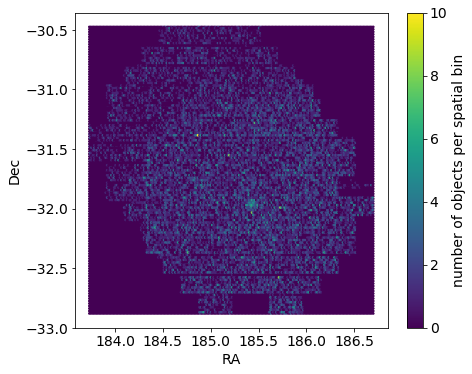

In [243]:
im = p.hexbin(R['ra'], R['dec'],gridsize=200)
p.xlabel('RA'); p.ylabel('Dec')
p.colorbar(label='number of objects per spatial bin');

In [244]:
def dwarf_filter (ra,dec,gmag,fwhm_small=2.0,fwhm_big=20,pix_scale=2):

    # Based on Koposov et al. (2008).
    # Code by Ken Mighell and Mike Fitzpatrick.
    # Minor edits by RN.
    
    x, y = ra.copy(), dec.copy()

    print "Computing differential convolution .... ",
    sys.stdout.flush()

    # Information about declination (y) [degrees]
    ymean = (y.min() + y.max()) / 2.0
    ydiff_arcmin = (y.max() - y.min()) * 60.0 # convert from degrees to arcmin

    # Information about right ascension (x) [degrees in time]:
    xdiff = x.max() - x.min() # angular separation [degrees (time)] 
    xmean = (x.min() + x.max())/2.0

    # convert from degrees in time to separation in angular degrees:
    xdiff_angular = (x.max() - x.min()) * np.cos(ymean*(np.pi/180.0))

    # convert from degress to arcmin
    xdiff_angular_arcmin = xdiff_angular * 60.0 

    # Get the number of one-arcmin pixels in the X and Y directions:
    nx = np.rint (xdiff_angular_arcmin/pix_scale).astype('int')
    ny = np.rint (ydiff_arcmin/pix_scale).astype('int')

    print nx,ny
    
    # Create a two-dimensional histogram of the raw counts:
    #Counts, xedges, yedges  = np.histogram2d (x, y, (nx,ny) )
    #extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]
    #raw_hist = np.rot90(Counts).copy() # hack around Pythonic weirdness

    #make a cut in magnitude space around where Hydra should be
    glower = 24.
    gupper = 25.
    cut = np.logical_and(gmag>glower,gmag<gupper)
    
    ramin,ramax = np.min(ra),np.max(ra)
    decmin,decmax = np.min(dec),np.max(dec)
    ran = [[ramin,ramax],[decmin,decmax]]
    
    # Create a two-dimensional histogram of the raw counts in hydra region:
    Counts_hydra, xedges_hydra, yedges_hydra  = np.histogram2d (x[cut], y[cut], (nx,ny), range=ran )
    extent_hydra = [xedges_hydra[0], xedges_hydra[-1], yedges_hydra[0], yedges_hydra[-1]]
    raw_hist_hydra = np.rot90(Counts_hydra).copy() # hack around Pythonic weirdness    
    
    # Create a two-dimensional histogram of the raw counts in hydra region:
    Counts_offhydra, xedges_offhydra, yedges_offhydra  = np.histogram2d (x[~cut], y[~cut], (nx,ny), range=ran )
    extent_offhydra = [xedges_offhydra[0], xedges_offhydra[-1], yedges_offhydra[0], yedges_offhydra[-1]]
    raw_hist_offhydra = np.rot90(Counts_offhydra).copy() # hack around Pythonic weirdness 
    
    
    temp = np.ma.masked_equal(raw_hist_offhydra,0)
    #print(raw_hist_hydra)
    #p.imshow(raw_hist_hydra)
    #p.colorbar(orientation='vertical')
    #p.title('on')
    #p.show()
    #print(temp)
    #p.imshow(temp)
    #p.colorbar(orientation='vertical')
    #p.title('off')
    #p.show()
    
    raw_hist = raw_hist_hydra / temp
    
    p.imshow(raw_hist)
    p.colorbar(orientation='vertical')
    p.title('ratioed -- %d' % pix_scale)
    p.show() 
    
    print(raw_hist_hydra.sum(),raw_hist_offhydra.sum())
    print("raw hist nanmax: %d nanmin: %d" % (np.nanmax(raw_hist),np.nanmin(raw_hist)))
    
    
    # Make the small and big Gaussian kernels with a standard deviation
    # of the given FWHM in arcmin^2 pixels.
    kernel_small = convolution.Gaussian2DKernel(fwhm_small/2.35,factor=1)
    kernel_big = convolution.Gaussian2DKernel(fwhm_big/2.35,factor=1)

    # Compute the differential convolution kerne
    conv_big = convolution.convolve (raw_hist, kernel_big)
    conv_small = convolution.convolve (raw_hist, kernel_small)
    conv_delta = conv_small - conv_big
    delta = conv_delta.copy()

    # Compute statistics and the floor
    mean = np.nanmean (delta, dtype='float64')
    sigma = np.nanstd (delta, dtype='float64')
    sigmaRaw = np.nanstd(raw_hist,dtype='float64')
    median = np.nanmedian (delta)                       # not used
    floor = mean 

    print 'dwarf_filter: mean = %g  sigma = %g sigmaRaw = %g' % (mean, sigma, sigmaRaw)

    # Clip to specified limits.
    clipped = delta.copy()
    clipped[ delta < floor ] = floor

    # Return the computed fields.
    return raw_hist, extent, delta, clipped, sigma

# Run the dwarf filter
We'll use the default convolution kernels of 2 and 20 arcminutes in size.

Computing differential convolution ....  152 144


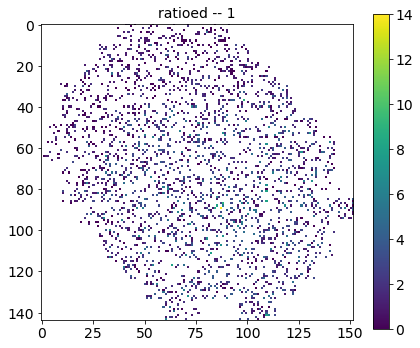

(28305.0, 2786.0)
raw hist nanmax: 14 nanmin: 0
dwarf_filter: mean = 0.0117277  sigma = 0.616517 sigmaRaw = 1.60792


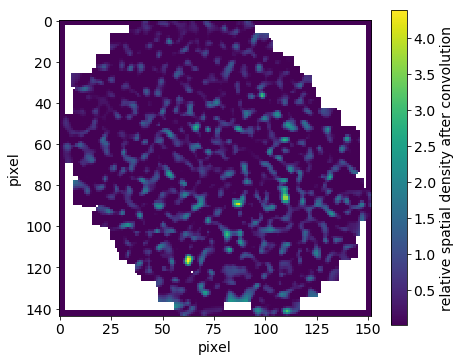

Computing differential convolution ....  76 72


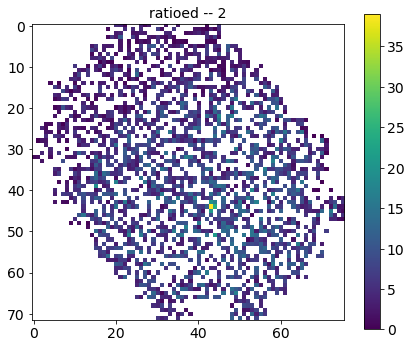

(28305.0, 2786.0)
raw hist nanmax: 39 nanmin: 0
dwarf_filter: mean = -0.0170553  sigma = 1.06206 sigmaRaw = 3.90842


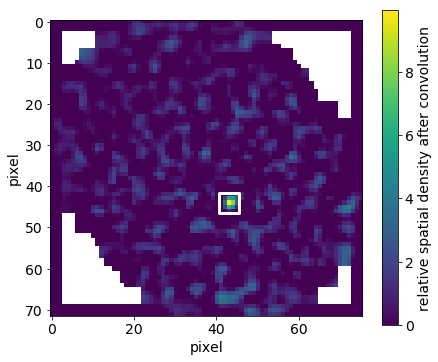

Computing differential convolution ....  51 48


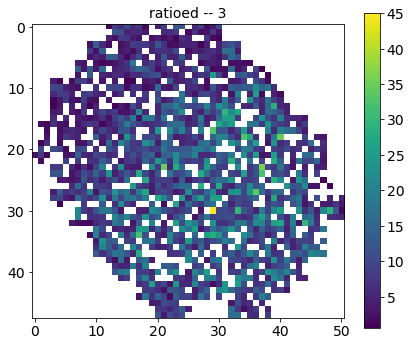

(28305.0, 2786.0)
raw hist nanmax: 45 nanmin: 0
dwarf_filter: mean = 0.00234221  sigma = 1.72609 sigmaRaw = 6.82484


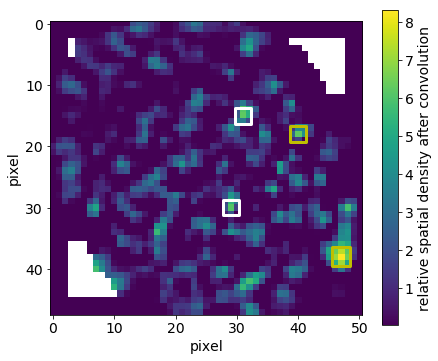

Computing differential convolution ....  38 36


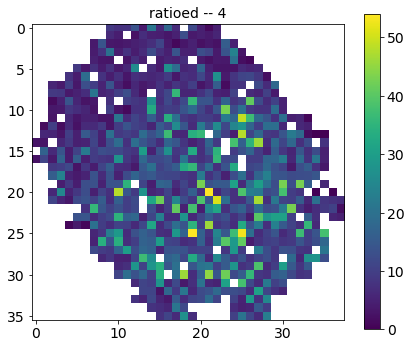

(28305.0, 2786.0)
raw hist nanmax: 54 nanmin: 0
dwarf_filter: mean = 0.173334  sigma = 2.26782 sigmaRaw = 9.59393


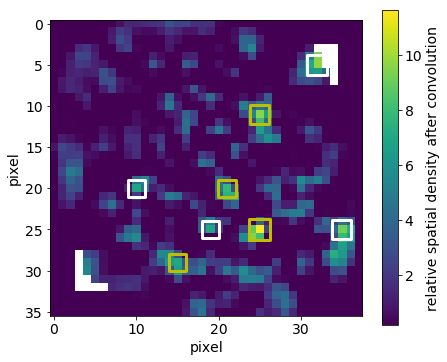

In [245]:
small_k, big_k = 2., 20./4.
for i in range(4):
    raw, extent, delta, clipped, dsigma = dwarf_filter(R['ra'],R['dec'],R['gmag'],fwhm_small=small_k,
                                                       fwhm_big=big_k,pix_scale=i+1)
    fig, ax = p.subplots()
    im = p.imshow(clipped)
    p.xlabel('pixel')
    p.ylabel('pixel')
    p.colorbar(label='relative spatial density after convolution');
    # find peaks
    mean, median, std = stats.sigma_clipped_stats(clipped,sigma=3.0,iters=5)    
    tbl = find_peaks(clipped,median+6,box_size=small_k*2)
    A = tbl.as_array()

    # add ra & dec positions of peaks found
    a, b = extent[:2]
    xvec = np.arange(a,b,(b-a)/clipped.shape[1])
    a, b = extent[2:]
    yvec = np.arange(a,b,(b-a)/clipped.shape[0])

    tbl['ra'] = xvec[tbl['x_peak']]
    tbl['dec'] = yvec[-tbl['y_peak']-1]
    
    ecs = ['w','y']
    ax.scatter(tbl['x_peak'],tbl['y_peak'],marker='s',s=tbl['peak_value']*40,c='none',edgecolors=ecs,lw=3) # keeps writing to previous ax
    fig  # repeats (the updated) figure
    p.show()

# Plot the convolved 2D histogram

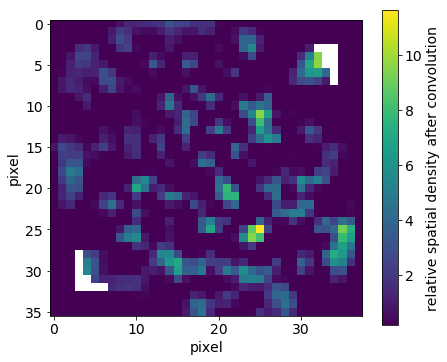

In [246]:
fig, ax = p.subplots()
im = p.imshow(clipped)
p.xlabel('pixel')
p.ylabel('pixel')
p.colorbar(label='relative spatial density after convolution');

<a class="anchor" id="peaks"></a>
# Identify peaks
We'll use the `photutils` package to identify 10-sigma peaks in the clipped filtered image.

In [209]:
# find peaks
mean, median, std = stats.sigma_clipped_stats(clipped,sigma=3.0,iters=5)    
tbl = find_peaks(clipped,median+6,box_size=small_k*2)
A = tbl.as_array()

# add ra & dec positions of peaks found
a, b = extent[:2]
xvec = np.arange(a,b,(b-a)/clipped.shape[1])
a, b = extent[2:]
yvec = np.arange(a,b,(b-a)/clipped.shape[0])

tbl['ra'] = xvec[tbl['x_peak']]
tbl['dec'] = yvec[-tbl['y_peak']-1]
print tbl

x_peak y_peak  peak_value       ra           dec      
------ ------ ------------ ------------ --------------
    43     44 9.9386097438 185.41127946 -31.9757217101


# Show the identified density peaks

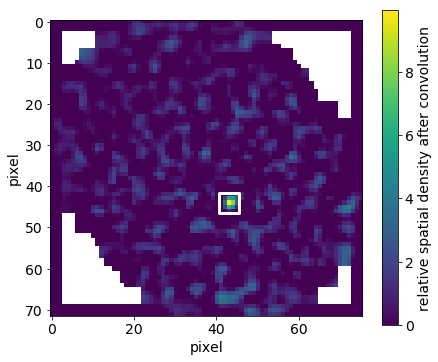

In [210]:
ecs = ['w','y']
ax.scatter(tbl['x_peak'],tbl['y_peak'],marker='s',s=tbl['peak_value']*40,c='none',edgecolors=ecs,lw=3) # keeps writing to previous ax
fig  # repeats (the updated) figure

<a class="anchor" id="sia"></a>
# Inspect the image cutouts around the peaks
# (Simple Image Access service)
Data Lab comes with batteries included. An image cutout and download service are built in.

In [13]:
# set up SIA
from pyvo.dal import sia
#DEF_ACCESS_URL = "http://datalab.noao.edu/sia/smash"
DEF_ACCESS_URL = "http://zeus1.sdm.noao.edu/siapv1"
svc = sia.SIAService(DEF_ACCESS_URL)

# a little func to download the deepest stacked images
def download_deepest_images(ra,dec,fov=0.1,bands=list('gri')):
    imgTable = svc.search((ra,dec), (fov/np.cos(dec*np.pi/180), fov), verbosity=2).votable.to_table()
    print "The full image list contains", len(imgTable), "entries"
    
    sel0 = (imgTable['proctype']=='Stacked') & (imgTable['prodtype']=='image') # basic selection
    images = []
    for band in bands:
        print "Band %s:" % band,
        sel = sel0 & (imgTable['obs_bandpass']==band) # add 'band' to selection
        Table = imgTable[sel] # select
        row = Table[np.argmax(Table['exptime'].data.data.astype('float'))] # pick image with longest exposure time
        url = row['access_url'] # get the download URL
        print 'downloading deepest stacked image...'
        img = io.fits.getdata(utils.data.download_file(url,cache=True,show_progress=False,timeout=120))
        images.append(img)
        
    print "Downloaded %d images." % len(images)
    return images

# multi panel image plotter
def plot_images(images,geo=None,panelsize=4,bands=list('gri'),cmap=matplotlib.cm.gray_r):
    n = len(images)
    if geo is None: geo = (n,1)
        
    fig = p.figure(figsize=(geo[0]*panelsize,geo[1]*panelsize))
    for j,img in enumerate(images):
        ax = fig.add_subplot(geo[1],geo[0],j+1)
        ax.imshow(img,origin='lower',interpolation='none',cmap=cmap,norm=matplotlib.colors.PowerNorm(0.2,vmin=1.01*img.min(),vmax=0.3*img.max()))
        ax.set_title('%s band' % bands[j])
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)

# Get images for the "left yellow" box

In [14]:
bands = list('gri')
images = download_deepest_images(tbl['ra'][1], tbl['dec'][1], fov=0.07, bands=bands) # FOV in deg

The full image list contains 2514 entries
Band g: downloading deepest stacked image...
Band r: downloading deepest stacked image...
Band i: downloading deepest stacked image...
Downloaded 3 images.


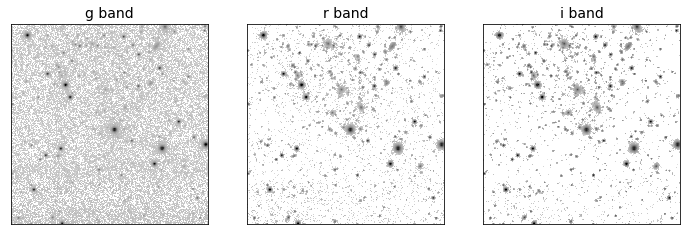

In [15]:
plot_images(images,bands=bands)

**Looks like a galaxy cluster!**

# Now the "white center box" object

The full image list contains 2718 entries
Band g: downloading deepest stacked image...
Band r: downloading deepest stacked image...
Band i: downloading deepest stacked image...
Downloaded 3 images.


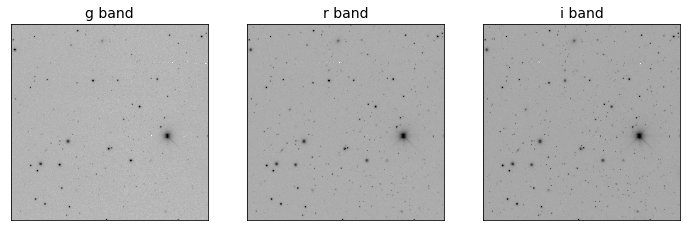

In [16]:
images = download_deepest_images(tbl['ra'][0], tbl['dec'][0])
plot_images(images)

**Doesn't look like much... but there's a dwarf galaxy in there!**

<a class="anchor" id="cmdiagrams"></a>
# Query the database for stars near peaks
Get photometry of stars within a 5 arcmin radius of each density peak.

A little helper function (**"Thou shalt never repeat thyself in thy code"**)

In [17]:
def makequery(ra0,dec0,radius0=5./60.,field=169,depth=1):
    query =\
    """SELECT ra,dec,gmag,rmag,imag FROM smash_dr1.object
       WHERE fieldid = '%d' AND
           depthflag > %d AND
           abs(sharp) < 0.5 AND
           gmag BETWEEN 9 AND 25 AND
           q3c_radial_query(ra,dec,%s,%s,%s)
    """ % (field, depth,ra0,dec0,radius0)
    
    return query

In [18]:
query1 = makequery(tbl['ra'][0],tbl['dec'][0]) # center ra & dec
R1 = Q(query1,outfmt='pandas')
print len(R1), "objects found."

Returning Pandas dataframe
2333 objects found.


# Compute color columns

In [133]:
R1['g_r'] = R1['gmag'] - R1['rmag']
R1['g_i'] = R1['gmag'] - R1['imag']
R1.tail()

,ra,dec,gmag,rmag,imag,g_r,g_i
2328,185.474249,-31.920428,24.4443,24.1614,24.0371,0.2829,0.4072
2329,185.478490,-31.921857,24.7771,24.4996,24.3937,0.2775,0.3834
2330,185.475582,-31.918164,24.6640,24.9536,24.7214,-0.2896,-0.0574
2331,185.472299,-31.916688,24.4480,24.6672,24.7170,-0.2192,-0.2690
2332,185.468940,-31.910392,24.9769,24.4817,24.2284,0.4952,0.7485


# Now the other peak

In [134]:
query2 = makequery(tbl['ra'][1],tbl['dec'][1])
R2 = Q(query2,outfmt='pandas')
print len(R2), "objects found."

# compute colors
R2['g_r'] = R2['gmag'] - R2['rmag']
R2['g_i'] = R2['gmag'] - R2['imag']

IndexError: index 1 is out of bounds for axis 0 with size 0

# Color-magnitude diagrams of the peaks

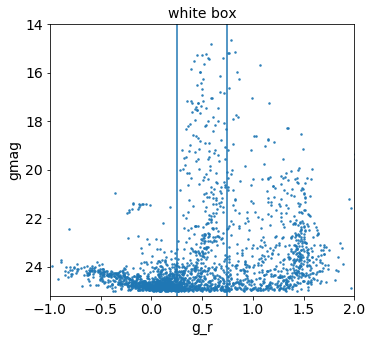

In [137]:
def plotpanel(axid,x,y,title='',xlim=(-1,2),ylim=(25.2,14)):
    ax = fig.add_subplot(axid)
    ax.scatter(x,y,marker='.',s=10, alpha=0.8)
    ax.set_xlabel(x.name)
    ax.set_ylabel(y.name)
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    ax.set_title(title)
    
fig = p.figure(figsize=(12,5))
plotpanel(121,R1['g_r'],R1['gmag'],'white box')
p.axvline(0.25)
p.axvline(0.75)
#plotpanel(122,R2['g_r'],R2['gmag'],'yellow box')

# Compare w/ Vivas+2016
![title](Vivas2016fig9.png)

<a class="anchor" id="getlightcurve"></a>
# Time-series analysis of a RR Lyrae star in Hydra II
Let's study the variability of an astrophysical object. In the Hydra II dwarf galaxy, one object is highly variable; it is a RR Lyrae star. We'll get the measurements for it from the SMASH survey's `source` table.

# Get lightcurves of one object
We can retrieve all calibrated magnitudes of a specific object, for all bands, and all epochs, from the `source` table.

In [22]:
objID = '169.429960' # this happens to be a RR Lyrae star in Hydra II
# select columns modified Julian date, calibrated mag, filter
# note: the DB encodes 'no measurement' values as 99.99
query = "SELECT ra,dec,mjd,cmag,cerr,filter FROM smash_dr1.source WHERE id='%s' AND cmag<99 ORDER BY mjd ASC" % objID

df = Q(query,outfmt='pandas',preview=2)

Returning Pandas dataframe
RESULT PREVIEW (2 rows)
ra,dec,mjd,cmag,cerr,filter
185.431155383634,-31.9953268802986,56371.3275383739,21.4331,0.0206513,g
185.431146196886,-31.9953236127704,56371.3285625321,21.2316,0.0224732,r


# Plot light-curves per-band
Plot the light-curves of this source separately for every band. We also zoom in on a range of dates with interesting measurements.

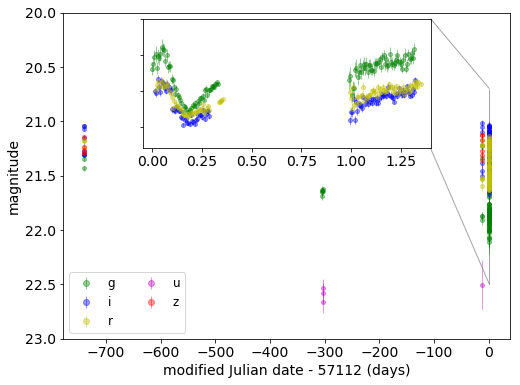

In [23]:
fig, ax = p.subplots(figsize=[8, 6]) # main panel
axins = inset_axes(ax, 4, 1.8, loc=9) # inset
filters = np.unique(df['filter'])
colors = dict(zip(filters,('g','b','y','m','r'))) # plotting colors
jd0 = 57112
start = 16 # in the inset we'll zoom in on some data
for filt in filters:
    sel = (df['filter'] == filt) # select one filter
    t = df['mjd'][sel].values
    y = df['cmag'][sel].values
    dy = df['cerr'][sel].values
    c = colors[filt]
    ax.errorbar(t-jd0,y,yerr=dy,marker='.',ms=8,ls='none',lw=1,color=c,alpha=0.4,label=filt)
    axins.errorbar(t[start:]-jd0,y[start:],yerr=dy[start:],marker='.',ms=8,ls='none',lw=1,color=c,alpha=0.4,label=filt)

# Main panel chores
ax.set_xlabel('modified Julian date - %d (days)' % jd0)
ax.set_ylabel('magnitude')
ax.set_ylim(23,20)
ax.legend(loc='lower left',frameon=True,ncol=2,markerscale=1.5)

# Inset magic
axins.yaxis.set_major_formatter(NullFormatter())
x1, x2, y1, y2 = -0.05, 1.4, 22.5, 20.7 # sub region of the original image
axins.set_xlim(x1, x2)
axins.set_ylim(y2, y1)

# draw bbox around inset; connect with parent axes
mark_inset(ax, axins, loc1=1, loc2=4, fc="none", ec="0.5",lw=1,alpha=0.7);

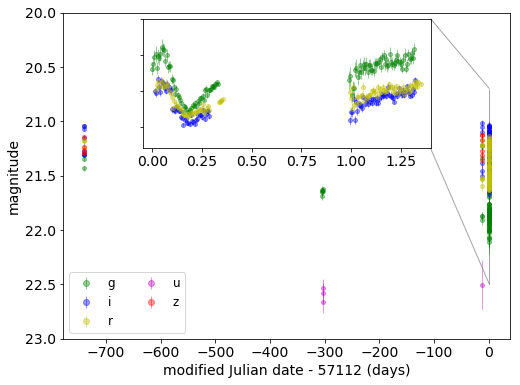

In [24]:
fig

<a class="anchor" id="lombscargle"></a>
# Find periodicity
One of many methods for finding the period of a variable is the Lomb-Scargle periodogram. It works in the Fourier domain. We'll apply it here to all g band measurements of our RR Lyrae star.

In [25]:
filt = 'g'
sel = (df['filter'] == filt)
t = df['mjd'][sel].values
y = df['cmag'][sel].values
dy = df['cerr'][sel].values

ls = stats.LombScargle(t, y)
# min freq = 1/longest expected period (in days)
# max freq = 1/shortest expected perdiod (in days)
# RR Lyrae usually have a period of a fraction of one day
frequency, power = ls.autopower(minimum_frequency=1./1.,maximum_frequency=1./0.1)

period = 1./frequency # period is the inverse of frequency
best_period = 1./frequency[np.argmax(power)]  # period with most power / strongest signal

# Plot periodogram (or "variogram")

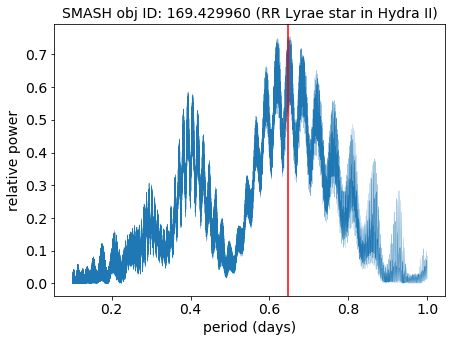

In [26]:
fig = p.figure(figsize=(7,5))
p.plot(period,power,lw=0.2)
p.xlabel('period (days)')
p.ylabel('relative power')
p.title('SMASH obj ID: 169.429960 (RR Lyrae star in Hydra II)')
p.axvline(best_period,color='r');

Best period: 0.648145563431 days


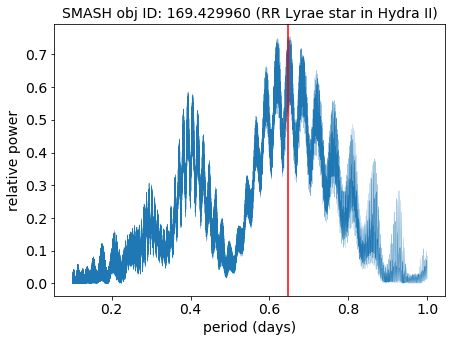

In [27]:
print "Best period:", best_period, "days"
fig

[Vivas et al. 2016](http://adsabs.harvard.edu/abs/2016AJ....151..118V) found with a (complementary!) phase dispersion minimization technique a period of 0.645 days. **We're in excellent agreement :-)**

<a class="anchor" id="phase"></a>
# Phase the entire lightcurve and plot it

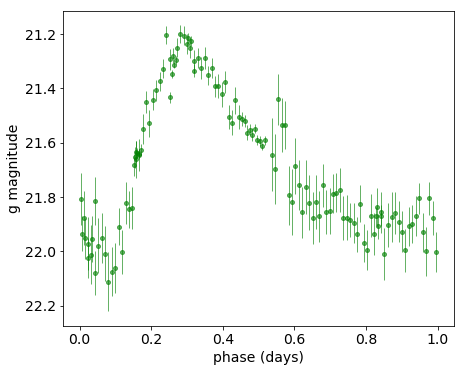

In [28]:
# light curve over period, take the remainder (i.e. the "phase" of one period)
phase = (t / best_period) % 1
fig, ax = p.subplots()
ax.errorbar(phase,y,yerr=dy,marker='.',ms=8,ls='none',lw=1,color='g',alpha=0.6)
ax.invert_yaxis()
ax.set_xlabel('phase (days)')
ax.set_ylabel('%s magnitude' % filt);

# Compute the Lomb-Scargle model

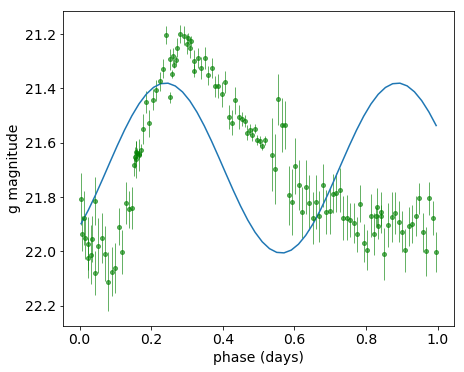

In [29]:
t_fit = np.linspace(phase.min(), phase.max())
y_fit = stats.LombScargle(t, y).model(t_fit, 1./best_period)
ax.plot(t_fit,y_fit) # keeps writing to current figure
fig  # repeats the (possibly updated) figure

**A simple sinusoid is not a good model for RR Lyrae pulsations!!** --> Hack idea: fit more realistic models, e.g. via RR Lyrae templates.

# Some resources


Nidever et al. (submitted) "SMASH - Survey of the MAgellanic Stellar History": http://adsabs.harvard.edu/abs/2017arXiv170100502N

Koposov et al. (2008, ApJ, 686, 279) "The Luminosity Function of the Milky Way Satellites": http://adsabs.harvard.edu/abs/2008ApJ...686..279K

Martin et al. (2015, ApJ, 804, 5) "Hydra II: A Faint and Compact Milky Way Dwarf Galaxy Found in the Survey of the Magellanic Stellar History": http://adsabs.harvard.edu/abs/2015ApJ...804L...5M

Vivas et al. 2016 (2016, AJ, 151, 118) "Variable Stars in the Field of the Hydra II Ultra-Faint Dwarf Galaxy": http://adsabs.harvard.edu/abs/2016AJ....151..118V

Jake VanderPlas' blog on Lomb-Scargle periodograms and on fitting RR Lyrae lightcurves with templates: https://jakevdp.github.io/blog/2015/06/13/lomb-scargle-in-python/

Lomb-Scargle periodograms in `astropy`: http://docs.astropy.org/en/stable/stats/lombscargle.html

RR Lyrae variables on wikipedia: https://en.wikipedia.org/wiki/RR_Lyrae_variable

# Hack ideas

* Find overdensities elsewhere; optimize

* Fit more physical RR Lyrae models, e.g. via templates

* Find "all" variable objects in DECaLS or SMASH and classify them (ML, random forest, ...)